In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR


## create DFM model BMI object

In [6]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/DFM


## intitialize DFM model first to expose 1d coords

In [7]:
# initialize DFM to expose model coordinates via BMI
DFM_bmi.initialize()

## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

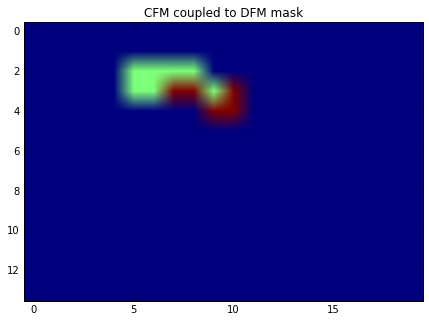

In [8]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(PCR_bmi.coupled_mask, vmin=0, vmax=2)
b.set_title('CFM coupled to DFM mask')

In [9]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-22 20:05:52.114093
2018-03-22 20:05:52,178 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-22 20:05:52.114093
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T20:05:52.114093.log
2018-03-22 20:05:52,179 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T20:05:52.114093.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-22 20:05:52,181 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. No

## run coupled PCR - DFM model

In [10]:
# run coupled model for 2 timesteps
def get_PCR_delta_vol():
    # coupled 2d mask
    mask = (PCR_bmi.coupled_mask > 0).astype(float)
    # Q outflow 2D for coupled cells
    # NOTE: see if we can change this for cell inflow, like with the get_CMF_delta_vol
    q_out = PCR_bmi.get_var('discharge') * mask # [m3/s]
    # PCR runoff inflow 2D for coupled cells
    runoff = PCR_bmi.get_var('runoff') * mask # [m3/s]
    # take discharge in most upstream coupled cells, runoff for other cells
    tot_flux = np.where(PCR_bmi.coupled_mask == 2, q_out, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * PCR_bmi.options['dt'] # [m3/day]
    return delta_vol 


DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac

def set_DFM_forcing():
    PCR_delta_vol = get_PCR_delta_vol() # 2d array [m3/day]
    print np.sum(PCR_delta_vol)
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return PCR_delta_vol

In [11]:
tStart = datetime.now()
# for i in range(timeSteps):
for i in range(365):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-22 20:06:06,479 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-22 20:06:06,752 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-22 20:06:08,893 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-22 20:06:09,500 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-22 20:06:09,503 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO: pcrglobwb.update(): updating model to time 2000-01-02
2018-03-22 20:06:09,881 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-03-22 20:06:10,982 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
2018-03-22 20:06:11,155 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-03
2018-03-22 20:06:11,582 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-03-22 20:06:12,712 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
2018-03-22 20:06:13,096 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-04
2018-03-22 20:06:13,103 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04
INFO: pcrglobwb.update(): updating model to time 2000-01-04
2018-03-22 20:06:13,494 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4
2018-03-22 20:06:14,616 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-04, timestep 4


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
2018-03-22 20:06:14,860 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 345600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-05
2018-03-22 20:06:14,870 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05
INFO: pcrglobwb.update(): updating model to time 2000-01-05
2018-03-22 20:06:15,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
2018-03-22 20:06:16,407 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-05, timestep 5
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 432000.0, timestep 86400.0
2018-03-22 20:06:16,568 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 432000.0, timestep 8640

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-06
2018-03-22 20:06:16,930 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6
2018-03-22 20:06:18,107 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-06, timestep 6


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
2018-03-22 20:06:18,427 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 518400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-07
2018-03-22 20:06:18,435 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07
INFO: pcrglobwb.update(): updating model to time 2000-01-07
2018-03-22 20:06:18,864 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7
2018-03-22 20:06:20,009 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-07, timestep 7


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
2018-03-22 20:06:20,400 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 604800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-08
2018-03-22 20:06:20,406 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08
INFO: pcrglobwb.update(): updating model to time 2000-01-08
2018-03-22 20:06:20,827 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
2018-03-22 20:06:21,963 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-08, timestep 8
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-22 20:06:22,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 8640

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-22 20:06:22,519 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-22 20:06:23,657 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
2018-03-22 20:06:23,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 777600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-10
2018-03-22 20:06:23,789 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-10
2018-03-22 20:06:24,246 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
2018-03-22 20:06:25,413 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-10, timestep 10
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
2018-03-22 20:06:25,573 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-22 20:06:25,578 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-22 20:06:25,923 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-22 20:06:27,076 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
2018-03-22 20:06:27,217 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 950400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-22 20:06:27,223 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-12
2018-03-22 20:06:27,662 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12
2018-03-22 20:06:28,780 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-12, timestep 12


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
2018-03-22 20:06:29,235 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1036800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-13
2018-03-22 20:06:29,241 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13
INFO: pcrglobwb.update(): updating model to time 2000-01-13
2018-03-22 20:06:29,590 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
2018-03-22 20:06:30,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-13, timestep 13
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1123200.0, timestep 86400.0
2018-03-22 20:06:30,827 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1123200.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-14
2018-03-22 20:06:31,277 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14
2018-03-22 20:06:32,407 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-14, timestep 14


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
2018-03-22 20:06:32,864 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1209600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-15
2018-03-22 20:06:32,869 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15
INFO: pcrglobwb.update(): updating model to time 2000-01-15
2018-03-22 20:06:33,285 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15
2018-03-22 20:06:34,406 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-15, timestep 15


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
2018-03-22 20:06:34,637 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1296000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-16
2018-03-22 20:06:34,643 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16
INFO: pcrglobwb.update(): updating model to time 2000-01-16
2018-03-22 20:06:35,060 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16
2018-03-22 20:06:36,213 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-16, timestep 16


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-22 20:06:36,500 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-22 20:06:36,504 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-22 20:06:36,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-22 20:06:38,054 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1468800.0, timestep 86400.0
2018-03-22 20:06:38,160 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1468800.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-18
2018-03-22 20:06:38,520 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
2018-03-22 20:06:39,624 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-18, timestep 18
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
2018-03-22 20:06:39,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-19
2018-03-22 20:06:39,760 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-19
2018-03-22 20:06:40,041 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19
2018-03-22 20:06:41,179 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-19, timestep 19


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
2018-03-22 20:06:41,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1641600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-20
2018-03-22 20:06:41,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20
INFO: pcrglobwb.update(): updating model to time 2000-01-20
2018-03-22 20:06:41,885 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
2018-03-22 20:06:43,022 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-20, timestep 20
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1728000.0, timestep 86400.0
2018-03-22 20:06:43,144 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1728000.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-03-22 20:06:43,478 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-22 20:06:44,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
2018-03-22 20:06:44,693 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1814400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-03-22 20:06:44,699 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-22
2018-03-22 20:06:45,162 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22
2018-03-22 20:06:46,256 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-22, timestep 22


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
2018-03-22 20:06:46,712 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1900800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-23
2018-03-22 20:06:46,717 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
INFO: pcrglobwb.update(): updating model to time 2000-01-23
2018-03-22 20:06:47,147 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-23, timestep 23
2018-03-22 20:06:48,301 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-23, timestep 23


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
2018-03-22 20:06:48,835 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1987200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-24
2018-03-22 20:06:48,837 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-24
INFO: pcrglobwb.update(): updating model to time 2000-01-24
2018-03-22 20:06:49,287 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-22 20:06:50,457 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-22 20:06:50,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-22 20:06:51,095 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-25, timestep 25
2018-03-22 20:06:52,247 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-25, timestep 25
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
2018-03-22 20:06:52,414 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2160000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-26
2018-03-22 20:06:52,420 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-26


nan


INFO: pcrglobwb.update(): updating model to time 2000-01-26
2018-03-22 20:06:52,783 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-26, timestep 26
2018-03-22 20:06:53,916 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-26, timestep 26


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
2018-03-22 20:06:54,189 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-27
2018-03-22 20:06:54,196 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-27
INFO: pcrglobwb.update(): updating model to time 2000-01-27
2018-03-22 20:06:54,640 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-27, timestep 27
2018-03-22 20:06:55,730 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-27, timestep 27


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
2018-03-22 20:06:56,103 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2332800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-28
2018-03-22 20:06:56,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-28
INFO: pcrglobwb.update(): updating model to time 2000-01-28
2018-03-22 20:06:56,537 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-28, timestep 28
2018-03-22 20:06:57,662 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-28, timestep 28


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
2018-03-22 20:06:57,888 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2419200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-29
2018-03-22 20:06:57,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-29
INFO: pcrglobwb.update(): updating model to time 2000-01-29
2018-03-22 20:06:58,308 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-29, timestep 29
2018-03-22 20:06:59,487 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-29, timestep 29


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
2018-03-22 20:06:59,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2505600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-30
2018-03-22 20:06:59,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-30
INFO: pcrglobwb.update(): updating model to time 2000-01-30
2018-03-22 20:07:00,381 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-30, timestep 30
2018-03-22 20:07:01,531 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-30, timestep 30
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2592000.0, timestep 86400.0
2018-03-22 20:07:01,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2592000.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-03-22 20:07:02,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-22 20:07:03,252 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
2018-03-22 20:07:03,470 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2678400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-03-22 20:07:03,476 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-22 20:07:03,900 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-22 20:07:05,308 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-22 20:07:05,467 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-02
2018-03-22 20:07:05,934 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
2018-03-22 20:07:07,075 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-02, timestep 33
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
2018-03-22 20:07:07,261 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-03
2018-03-22 20:07:07,266 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-03


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-03
2018-03-22 20:07:07,663 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-03, timestep 34
2018-03-22 20:07:08,778 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-03, timestep 34
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
2018-03-22 20:07:08,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-04
2018-03-22 20:07:08,944 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-04


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-04
2018-03-22 20:07:09,339 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-04, timestep 35
2018-03-22 20:07:10,468 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-04, timestep 35


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
2018-03-22 20:07:10,912 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3024000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-05
2018-03-22 20:07:10,916 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-05
INFO: pcrglobwb.update(): updating model to time 2000-02-05
2018-03-22 20:07:11,356 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-05, timestep 36
2018-03-22 20:07:12,493 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-05, timestep 36
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3110400.0, timestep 86400.0
2018-03-22 20:07:12,608 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3110400.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-06
2018-03-22 20:07:13,017 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-06, timestep 37
2018-03-22 20:07:14,171 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-06, timestep 37
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
2018-03-22 20:07:14,270 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3196800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-07
2018-03-22 20:07:14,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-07


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-07
2018-03-22 20:07:14,683 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-07, timestep 38
2018-03-22 20:07:15,827 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-07, timestep 38


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
2018-03-22 20:07:16,095 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3283200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-08
2018-03-22 20:07:16,101 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-08
INFO: pcrglobwb.update(): updating model to time 2000-02-08
2018-03-22 20:07:16,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-08, timestep 39
2018-03-22 20:07:17,703 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-08, timestep 39


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-22 20:07:17,956 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-22 20:07:17,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-22 20:07:18,402 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-22 20:07:19,563 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
2018-03-22 20:07:19,922 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3456000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-03-22 20:07:19,932 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-03-22 20:07:20,379 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-22 20:07:21,536 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
2018-03-22 20:07:21,862 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-03-22 20:07:21,867 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
INFO: pcrglobwb.update(): updating model to time 2000-02-11
2018-03-22 20:07:22,312 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-11, timestep 42
2018-03-22 20:07:23,498 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-11, timestep 42


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
2018-03-22 20:07:23,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3628800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-12
2018-03-22 20:07:23,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-12
INFO: pcrglobwb.update(): updating model to time 2000-02-12
2018-03-22 20:07:24,107 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43
2018-03-22 20:07:25,365 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-12, timestep 43


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
2018-03-22 20:07:25,882 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3715200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-13
2018-03-22 20:07:25,889 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
INFO: pcrglobwb.update(): updating model to time 2000-02-13
2018-03-22 20:07:26,358 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-13, timestep 44
2018-03-22 20:07:27,475 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-13, timestep 44
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3801600.0, timestep 86400.0
2018-03-22 20:07:27,586 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3801600.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-14
2018-03-22 20:07:28,026 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-14, timestep 45
2018-03-22 20:07:29,149 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-14, timestep 45
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
2018-03-22 20:07:29,316 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3888000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-15
2018-03-22 20:07:29,322 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-15


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-15
2018-03-22 20:07:29,740 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-15, timestep 46
2018-03-22 20:07:30,899 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-15, timestep 46


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
2018-03-22 20:07:31,117 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3974400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-16
2018-03-22 20:07:31,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-16
INFO: pcrglobwb.update(): updating model to time 2000-02-16
2018-03-22 20:07:31,520 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-16, timestep 47
2018-03-22 20:07:32,555 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-16, timestep 47


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-22 20:07:32,872 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-22 20:07:32,878 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-22 20:07:33,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-22 20:07:34,346 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
2018-03-22 20:07:34,576 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4147200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-18
2018-03-22 20:07:34,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-18
INFO: pcrglobwb.update(): updating model to time 2000-02-18
2018-03-22 20:07:34,928 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-18, timestep 49
2018-03-22 20:07:36,085 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-18, timestep 49
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4233600.0, timestep 86400.0
2018-03-22 20:07:36,260 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4233600.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-19
2018-03-22 20:07:36,637 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50
2018-03-22 20:07:37,756 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-19, timestep 50


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
2018-03-22 20:07:38,039 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4320000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-03-22 20:07:38,046 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-03-22 20:07:38,401 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-22 20:07:39,550 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4406400.0, timestep 86400.0
2018-03-22 20:07:39,641 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4406400.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-21
2018-03-22 20:07:39,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-21, timestep 52
2018-03-22 20:07:41,137 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-21, timestep 52
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
2018-03-22 20:07:41,326 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4492800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-22
2018-03-22 20:07:41,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-22
2018-03-22 20:07:41,746 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-22, timestep 53
2018-03-22 20:07:42,977 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-22, timestep 53
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
2018-03-22 20:07:43,160 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4579200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-23
2018-03-22 20:07:43,162 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-23
2018-03-22 20:07:43,564 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54
2018-03-22 20:07:44,694 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-23, timestep 54


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
2018-03-22 20:07:44,900 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4665600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-24
2018-03-22 20:07:44,903 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-24
INFO: pcrglobwb.update(): updating model to time 2000-02-24
2018-03-22 20:07:45,324 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-22 20:07:46,448 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-22 20:07:46,622 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-22 20:07:46,992 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-25, timestep 56
2018-03-22 20:07:48,090 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-25, timestep 56


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
2018-03-22 20:07:48,529 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4838400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-26
2018-03-22 20:07:48,536 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-26
INFO: pcrglobwb.update(): updating model to time 2000-02-26
2018-03-22 20:07:49,012 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-26, timestep 57
2018-03-22 20:07:50,157 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-26, timestep 57
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4924800.0, timestep 86400.0
2018-03-22 20:07:50,253 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4924800.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-02-27
2018-03-22 20:07:50,606 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-27, timestep 58
2018-03-22 20:07:51,756 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-27, timestep 58
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
2018-03-22 20:07:51,923 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5011200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-28
2018-03-22 20:07:51,928 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-28


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-28
2018-03-22 20:07:52,406 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-28, timestep 59
2018-03-22 20:07:53,624 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-28, timestep 59
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
2018-03-22 20:07:53,767 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5097600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-29
2018-03-22 20:07:53,773 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-29


nan


INFO: pcrglobwb.update(): updating model to time 2000-02-29
2018-03-22 20:07:54,209 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60
2018-03-22 20:07:55,358 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-29, timestep 60


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
2018-03-22 20:07:55,612 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5184000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-03-22 20:07:55,618 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-03-22 20:07:56,015 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-03-22 20:07:57,434 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5270400.0, timestep 86400.0
2018-03-22 20:07:57,568 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5270400.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-02
2018-03-22 20:07:58,016 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-02, timestep 62
2018-03-22 20:07:59,171 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-02, timestep 62


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
2018-03-22 20:07:59,567 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5356800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-03
2018-03-22 20:07:59,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-22 20:08:00,008 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-22 20:08:01,159 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-22 20:08:01,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-04
2018-03-22 20:08:01,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
2018-03-22 20:08:02,644 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-04, timestep 64
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
2018-03-22 20:08:02,796 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-05
2018-03-22 20:08:02,801 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-05
2018-03-22 20:08:03,128 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-05, timestep 65
2018-03-22 20:08:04,270 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-05, timestep 65
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
2018-03-22 20:08:04,402 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-06
2018-03-22 20:08:04,407 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-06


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-06
2018-03-22 20:08:04,851 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-06, timestep 66
2018-03-22 20:08:05,993 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-06, timestep 66


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
2018-03-22 20:08:06,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5702400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-07
2018-03-22 20:08:06,205 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-07
INFO: pcrglobwb.update(): updating model to time 2000-03-07
2018-03-22 20:08:06,655 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-07, timestep 67
2018-03-22 20:08:07,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-07, timestep 67
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5788800.0, timestep 86400.0
2018-03-22 20:08:07,907 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5788800.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-08
2018-03-22 20:08:08,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-08, timestep 68
2018-03-22 20:08:09,402 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-08, timestep 68


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
2018-03-22 20:08:09,682 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5875200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-09
2018-03-22 20:08:09,694 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-09
INFO: pcrglobwb.update(): updating model to time 2000-03-09
2018-03-22 20:08:10,062 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-09, timestep 69
2018-03-22 20:08:11,178 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-09, timestep 69
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5961600.0, timestep 86400.0
2018-03-22 20:08:11,291 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5961600.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-10
2018-03-22 20:08:11,632 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70
2018-03-22 20:08:12,797 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-10, timestep 70


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-22 20:08:13,062 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-22 20:08:13,069 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-22 20:08:13,456 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-22 20:08:14,621 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
2018-03-22 20:08:14,966 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6134400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-03-22 20:08:14,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
INFO: pcrglobwb.update(): updating model to time 2000-03-12
2018-03-22 20:08:15,435 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-12, timestep 72
2018-03-22 20:08:16,565 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-12, timestep 72


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
2018-03-22 20:08:17,030 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-13
2018-03-22 20:08:17,036 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-13
INFO: pcrglobwb.update(): updating model to time 2000-03-13
2018-03-22 20:08:17,391 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-13, timestep 73
2018-03-22 20:08:18,502 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-13, timestep 73


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
2018-03-22 20:08:18,848 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6307200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-14
2018-03-22 20:08:18,854 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-14
INFO: pcrglobwb.update(): updating model to time 2000-03-14
2018-03-22 20:08:19,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-14, timestep 74
2018-03-22 20:08:20,427 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-14, timestep 74
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6393600.0, timestep 86400.0
2018-03-22 20:08:20,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6393600.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-15
2018-03-22 20:08:21,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
2018-03-22 20:08:22,091 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-15, timestep 75
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
2018-03-22 20:08:22,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6480000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-16
2018-03-22 20:08:22,277 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-16


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-16
2018-03-22 20:08:22,642 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-16, timestep 76
2018-03-22 20:08:23,782 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-16, timestep 76


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
2018-03-22 20:08:24,172 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6566400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-17
2018-03-22 20:08:24,176 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-17
INFO: pcrglobwb.update(): updating model to time 2000-03-17
2018-03-22 20:08:24,667 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-17, timestep 77
2018-03-22 20:08:25,819 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-17, timestep 77


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
2018-03-22 20:08:26,026 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6652800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-18
2018-03-22 20:08:26,033 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-18
INFO: pcrglobwb.update(): updating model to time 2000-03-18
2018-03-22 20:08:26,421 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-18, timestep 78
2018-03-22 20:08:27,540 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-18, timestep 78
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-22 20:08:27,670 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-22 20:08:28,086 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-22 20:08:29,243 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
2018-03-22 20:08:29,415 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6825600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-20
2018-03-22 20:08:29,421 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-20


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-20
2018-03-22 20:08:29,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
2018-03-22 20:08:30,916 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-20, timestep 80
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
2018-03-22 20:08:30,996 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-03-22 20:08:31,001 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-03-22 20:08:31,340 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-03-22 20:08:32,494 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
2018-03-22 20:08:32,649 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6998400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-03-22 20:08:32,656 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-22
2018-03-22 20:08:33,028 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-22, timestep 82
2018-03-22 20:08:34,135 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-22, timestep 82
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
2018-03-22 20:08:34,286 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7084800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-23
2018-03-22 20:08:34,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-23


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-23
2018-03-22 20:08:34,706 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-23, timestep 83
2018-03-22 20:08:35,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-23, timestep 83
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
2018-03-22 20:08:36,088 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7171200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-24
2018-03-22 20:08:36,090 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-24


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-24
2018-03-22 20:08:36,396 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-24, timestep 84
2018-03-22 20:08:37,494 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-24, timestep 84
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
2018-03-22 20:08:37,641 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7257600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-25
2018-03-22 20:08:37,645 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-25


nan


INFO: pcrglobwb.update(): updating model to time 2000-03-25
2018-03-22 20:08:38,092 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85
2018-03-22 20:08:39,296 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-25, timestep 85


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
2018-03-22 20:08:39,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7344000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-26
2018-03-22 20:08:39,510 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-26
INFO: pcrglobwb.update(): updating model to time 2000-03-26
2018-03-22 20:08:39,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-22 20:08:41,042 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-22 20:08:41,412 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-22 20:08:41,415 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-22 20:08:41,844 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-27, timestep 87
2018-03-22 20:08:42,942 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-27, timestep 87


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
2018-03-22 20:08:43,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7516800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-28
2018-03-22 20:08:43,410 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-28
INFO: pcrglobwb.update(): updating model to time 2000-03-28
2018-03-22 20:08:43,868 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-28, timestep 88
2018-03-22 20:08:45,032 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-28, timestep 88


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
2018-03-22 20:08:45,314 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-29
2018-03-22 20:08:45,317 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-29
INFO: pcrglobwb.update(): updating model to time 2000-03-29
2018-03-22 20:08:45,747 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-29, timestep 89
2018-03-22 20:08:46,894 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-29, timestep 89


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
2018-03-22 20:08:47,111 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7689600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-30
2018-03-22 20:08:47,115 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-30
INFO: pcrglobwb.update(): updating model to time 2000-03-30
2018-03-22 20:08:47,509 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
2018-03-22 20:08:48,640 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-30, timestep 90
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7776000.0, timestep 86400.0
2018-03-22 20:08:48,763 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7776000.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-03-22 20:08:49,147 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-03-22 20:08:50,261 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
2018-03-22 20:08:50,501 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7862400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-03-22 20:08:50,511 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
INFO: pcrglobwb.update(): updating model to time 2000-04-01
2018-03-22 20:08:50,935 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-01, timestep 92
2018-03-22 20:08:52,372 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-01, timestep 92
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7948800.0, timestep 86400.0
2018-03-22 20:08:52,521 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7948800.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-02
2018-03-22 20:08:52,885 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-02, timestep 93
2018-03-22 20:08:54,028 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-02, timestep 93
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
2018-03-22 20:08:54,147 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8035200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-03
2018-03-22 20:08:54,149 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03


nan


INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-22 20:08:54,565 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-22 20:08:55,687 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-22 20:08:55,794 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-04
2018-03-22 20:08:55,796 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-04


nan


INFO: pcrglobwb.update(): updating model to time 2000-04-04
2018-03-22 20:08:56,197 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-04, timestep 95
2018-03-22 20:08:57,300 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-04, timestep 95


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
2018-03-22 20:08:57,606 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-05
2018-03-22 20:08:57,619 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-05
INFO: pcrglobwb.update(): updating model to time 2000-04-05
2018-03-22 20:08:58,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
2018-03-22 20:08:59,295 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-05, timestep 96
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8294400.0, timestep 86400.0
2018-03-22 20:08:59,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8294400.0, timeste

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-06
2018-03-22 20:08:59,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-06, timestep 97
2018-03-22 20:09:01,076 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-06, timestep 97
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
2018-03-22 20:09:01,232 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8380800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-07
2018-03-22 20:09:01,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-07


nan


INFO: pcrglobwb.update(): updating model to time 2000-04-07
2018-03-22 20:09:01,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-07, timestep 98
2018-03-22 20:09:02,853 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-07, timestep 98


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
2018-03-22 20:09:03,293 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8467200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-08
2018-03-22 20:09:03,298 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-08
INFO: pcrglobwb.update(): updating model to time 2000-04-08
2018-03-22 20:09:03,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99
2018-03-22 20:09:04,784 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-08, timestep 99


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
2018-03-22 20:09:05,119 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8553600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-09
2018-03-22 20:09:05,124 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-09
INFO: pcrglobwb.update(): updating model to time 2000-04-09
2018-03-22 20:09:05,509 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100
2018-03-22 20:09:06,673 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-09, timestep 100


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
2018-03-22 20:09:06,886 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8640000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-03-22 20:09:06,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-03-22 20:09:07,306 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-03-22 20:09:08,445 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-22 20:09:08,613 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, times

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-22 20:09:09,102 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-22 20:09:10,237 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
2018-03-22 20:09:10,356 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8812800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-12
2018-03-22 20:09:10,362 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-12


nan


INFO: pcrglobwb.update(): updating model to time 2000-04-12
2018-03-22 20:09:10,724 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-12, timestep 103
2018-03-22 20:09:11,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-12, timestep 103


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
2018-03-22 20:09:12,198 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-13
2018-03-22 20:09:12,204 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-13
INFO: pcrglobwb.update(): updating model to time 2000-04-13
2018-03-22 20:09:12,584 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-13, timestep 104
2018-03-22 20:09:13,805 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-13, timestep 104


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
2018-03-22 20:09:14,314 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8985600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-14
2018-03-22 20:09:14,317 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-14
INFO: pcrglobwb.update(): updating model to time 2000-04-14
2018-03-22 20:09:14,724 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-14, timestep 105
2018-03-22 20:09:15,873 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-14, timestep 105


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
2018-03-22 20:09:16,482 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9072000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-15
2018-03-22 20:09:16,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-15
INFO: pcrglobwb.update(): updating model to time 2000-04-15
2018-03-22 20:09:16,961 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
2018-03-22 20:09:18,136 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-15, timestep 106
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9158400.0, timestep 86400.0
2018-03-22 20:09:18,332 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9158400.0, times

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-16
2018-03-22 20:09:18,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-16, timestep 107
2018-03-22 20:09:20,044 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-16, timestep 107
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
2018-03-22 20:09:20,211 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9244800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-17
2018-03-22 20:09:20,213 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-17


nan


INFO: pcrglobwb.update(): updating model to time 2000-04-17
2018-03-22 20:09:20,641 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-17, timestep 108
2018-03-22 20:09:21,826 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-17, timestep 108


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
2018-03-22 20:09:22,171 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9331200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-18
2018-03-22 20:09:22,174 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-18
INFO: pcrglobwb.update(): updating model to time 2000-04-18
2018-03-22 20:09:22,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109
2018-03-22 20:09:23,765 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-18, timestep 109


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-22 20:09:24,121 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-22 20:09:24,126 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-22 20:09:24,541 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-22 20:09:25,738 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
2018-03-22 20:09:25,954 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9504000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-03-22 20:09:25,959 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-03-22 20:09:26,340 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-03-22 20:09:27,477 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9590400.0, timestep 86400.0
2018-03-22 20:09:27,612 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9590400.0, times

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-21
2018-03-22 20:09:27,968 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-21, timestep 112
2018-03-22 20:09:29,151 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-21, timestep 112


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
2018-03-22 20:09:29,714 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9676800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-22
2018-03-22 20:09:29,718 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-22
INFO: pcrglobwb.update(): updating model to time 2000-04-22
2018-03-22 20:09:30,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-22, timestep 113
2018-03-22 20:09:31,284 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-22, timestep 113


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
2018-03-22 20:09:31,563 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9763200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-23
2018-03-22 20:09:31,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-23
INFO: pcrglobwb.update(): updating model to time 2000-04-23
2018-03-22 20:09:31,963 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-23, timestep 114
2018-03-22 20:09:33,123 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-23, timestep 114


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
2018-03-22 20:09:33,341 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9849600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-24
2018-03-22 20:09:33,347 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-24
INFO: pcrglobwb.update(): updating model to time 2000-04-24
2018-03-22 20:09:33,811 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-24, timestep 115
2018-03-22 20:09:34,983 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-24, timestep 115


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
2018-03-22 20:09:35,221 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9936000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-25
2018-03-22 20:09:35,230 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-25
INFO: pcrglobwb.update(): updating model to time 2000-04-25
2018-03-22 20:09:35,634 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-25, timestep 116
2018-03-22 20:09:36,789 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-25, timestep 116
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10022400.0, timestep 86400.0
2018-03-22 20:09:36,920 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10022400.0, tim

nan


INFO: pcrglobwb.update(): updating model to time 2000-04-26
2018-03-22 20:09:37,356 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-22 20:09:38,484 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-22 20:09:38,714 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-22 20:09:38,718 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-22 20:09:39,142 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-27, timestep 118
2018-03-22 20:09:40,319 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-27, timestep 118


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
2018-03-22 20:09:40,878 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-28
2018-03-22 20:09:40,881 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-28
INFO: pcrglobwb.update(): updating model to time 2000-04-28
2018-03-22 20:09:41,423 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119
2018-03-22 20:09:42,601 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-28, timestep 119


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
2018-03-22 20:09:43,035 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10281600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-29
2018-03-22 20:09:43,041 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-29
INFO: pcrglobwb.update(): updating model to time 2000-04-29
2018-03-22 20:09:43,352 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-29, timestep 120
2018-03-22 20:09:44,499 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-29, timestep 120


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
2018-03-22 20:09:44,857 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10368000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-03-22 20:09:44,859 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-03-22 20:09:45,240 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-03-22 20:09:46,390 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
2018-03-22 20:09:46,609 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10454400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-01
2018-03-22 20:09:46,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-01
INFO: pcrglobwb.update(): updating model to time 2000-05-01
2018-03-22 20:09:47,049 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-01, timestep 122
2018-03-22 20:09:48,316 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-01, timestep 122
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10540800.0, timestep 86400.0
2018-03-22 20:09:48,449 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10540800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-05-02
2018-03-22 20:09:48,798 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-02, timestep 123
2018-03-22 20:09:49,948 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-02, timestep 123
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
2018-03-22 20:09:50,106 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10627200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-03
2018-03-22 20:09:50,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-03


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-03
2018-03-22 20:09:50,548 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-03, timestep 124
2018-03-22 20:09:51,735 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-03, timestep 124


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
2018-03-22 20:09:51,991 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10713600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-22 20:09:51,994 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-22 20:09:52,387 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-22 20:09:53,537 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-22 20:09:53,989 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-05
2018-03-22 20:09:53,997 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-05
INFO: pcrglobwb.update(): updating model to time 2000-05-05
2018-03-22 20:09:54,437 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-05, timestep 126
2018-03-22 20:09:55,578 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-05, timestep 126


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
2018-03-22 20:09:55,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-06
2018-03-22 20:09:55,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-06
INFO: pcrglobwb.update(): updating model to time 2000-05-06
2018-03-22 20:09:56,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
2018-03-22 20:09:57,455 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-06, timestep 127
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10972800.0, timestep 86400.0
2018-03-22 20:09:57,653 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10972800.0, t

nan


2018-03-22 20:09:57,657 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-07
INFO: pcrglobwb.update(): updating model to time 2000-05-07
2018-03-22 20:09:58,096 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-07, timestep 128
2018-03-22 20:09:59,278 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-07, timestep 128


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
2018-03-22 20:09:59,578 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11059200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-08
2018-03-22 20:09:59,582 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-08
INFO: pcrglobwb.update(): updating model to time 2000-05-08
2018-03-22 20:10:00,071 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
2018-03-22 20:10:01,225 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-08, timestep 129
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11145600.0, timestep 86400.0
2018-03-22 20:10:01,425 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11145600.0, t

nan


2018-03-22 20:10:01,429 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-09
INFO: pcrglobwb.update(): updating model to time 2000-05-09
2018-03-22 20:10:01,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
2018-03-22 20:10:03,009 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
2018-03-22 20:10:03,236 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11232000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-03-22 20:10:03,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-03-22 20:10:03,649 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-03-22 20:10:04,786 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
2018-03-22 20:10:05,026 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11318400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-11
2018-03-22 20:10:05,028 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-11
INFO: pcrglobwb.update(): updating model to time 2000-05-11
2018-03-22 20:10:05,369 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-11, timestep 132
2018-03-22 20:10:06,501 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-11, timestep 132
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-22 20:10:06,643 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-22 20:10:07,044 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-22 20:10:08,165 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
2018-03-22 20:10:08,325 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11491200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-13
2018-03-22 20:10:08,332 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-13


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-13
2018-03-22 20:10:08,775 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-13, timestep 134
2018-03-22 20:10:09,993 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-13, timestep 134
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
2018-03-22 20:10:10,158 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-14
2018-03-22 20:10:10,161 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-14


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-14
2018-03-22 20:10:10,682 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-14, timestep 135
2018-03-22 20:10:11,890 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-14, timestep 135
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
2018-03-22 20:10:12,011 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11664000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-15
2018-03-22 20:10:12,015 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-15


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-15
2018-03-22 20:10:12,428 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-15, timestep 136
2018-03-22 20:10:13,539 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-15, timestep 136


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
2018-03-22 20:10:13,972 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11750400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-16
2018-03-22 20:10:13,977 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-16
INFO: pcrglobwb.update(): updating model to time 2000-05-16
2018-03-22 20:10:14,428 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-16, timestep 137
2018-03-22 20:10:15,620 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-16, timestep 137


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
2018-03-22 20:10:16,014 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11836800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-17
2018-03-22 20:10:16,019 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-17
INFO: pcrglobwb.update(): updating model to time 2000-05-17
2018-03-22 20:10:16,420 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138
2018-03-22 20:10:17,551 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-17, timestep 138


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
2018-03-22 20:10:18,148 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11923200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-18
2018-03-22 20:10:18,152 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-18
INFO: pcrglobwb.update(): updating model to time 2000-05-18
2018-03-22 20:10:18,628 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139
2018-03-22 20:10:19,810 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-18, timestep 139


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
2018-03-22 20:10:20,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12009600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-19
2018-03-22 20:10:20,410 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-19
INFO: pcrglobwb.update(): updating model to time 2000-05-19
2018-03-22 20:10:20,846 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-03-22 20:10:22,033 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-22 20:10:22,175 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-22 20:10:22,673 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-22 20:10:23,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
2018-03-22 20:10:23,965 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12182400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-21
2018-03-22 20:10:23,970 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-21


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-21
2018-03-22 20:10:24,414 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-21, timestep 142
2018-03-22 20:10:25,579 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-21, timestep 142


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
2018-03-22 20:10:25,798 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12268800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-22
2018-03-22 20:10:25,803 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-22
INFO: pcrglobwb.update(): updating model to time 2000-05-22
2018-03-22 20:10:26,221 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-22, timestep 143
2018-03-22 20:10:27,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-22, timestep 143


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
2018-03-22 20:10:27,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12355200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-23
2018-03-22 20:10:27,761 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-23
INFO: pcrglobwb.update(): updating model to time 2000-05-23
2018-03-22 20:10:28,202 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-23, timestep 144
2018-03-22 20:10:29,311 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-23, timestep 144


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
2018-03-22 20:10:29,544 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12441600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-24
2018-03-22 20:10:29,551 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-24
INFO: pcrglobwb.update(): updating model to time 2000-05-24
2018-03-22 20:10:29,968 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-24, timestep 145
2018-03-22 20:10:31,093 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-24, timestep 145


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
2018-03-22 20:10:31,494 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12528000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-25
2018-03-22 20:10:31,500 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-25
INFO: pcrglobwb.update(): updating model to time 2000-05-25
2018-03-22 20:10:31,889 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-25, timestep 146
2018-03-22 20:10:33,012 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-25, timestep 146
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0


nan


2018-03-22 20:10:33,215 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12614400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-26
2018-03-22 20:10:33,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-26
INFO: pcrglobwb.update(): updating model to time 2000-05-26
2018-03-22 20:10:33,673 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-26, timestep 147
2018-03-22 20:10:34,808 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-26, timestep 147
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
2018-03-22 20:10:34,921 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12700800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-27
2018-03-22 20:1

nan


INFO: pcrglobwb.update(): updating model to time 2000-05-27
2018-03-22 20:10:35,360 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-22 20:10:36,532 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-22 20:10:36,619 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-22 20:10:36,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-28


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-28
2018-03-22 20:10:37,022 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
2018-03-22 20:10:38,174 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-28, timestep 149
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
2018-03-22 20:10:38,278 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-29
2018-03-22 20:10:38,283 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-29


nan


INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-03-22 20:10:38,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-03-22 20:10:39,865 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
2018-03-22 20:10:40,380 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12960000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-03-22 20:10:40,387 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-03-22 20:10:40,870 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-30, timestep 151
2018-03-22 20:10:42,016 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-30, timestep 151


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
2018-03-22 20:10:42,444 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13046400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-31
2018-03-22 20:10:42,449 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-31
INFO: pcrglobwb.update(): updating model to time 2000-05-31
2018-03-22 20:10:42,888 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-31, timestep 152
2018-03-22 20:10:44,029 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-31, timestep 152


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
2018-03-22 20:10:44,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13132800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-01
2018-03-22 20:10:44,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-01
INFO: pcrglobwb.update(): updating model to time 2000-06-01
2018-03-22 20:10:45,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-01, timestep 153
2018-03-22 20:10:46,535 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-01, timestep 153


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
2018-03-22 20:10:47,020 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13219200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-02
2018-03-22 20:10:47,026 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-02
INFO: pcrglobwb.update(): updating model to time 2000-06-02
2018-03-22 20:10:47,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-02, timestep 154
2018-03-22 20:10:48,601 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-02, timestep 154


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
2018-03-22 20:10:49,171 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13305600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-03
2018-03-22 20:10:49,175 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-03
INFO: pcrglobwb.update(): updating model to time 2000-06-03
2018-03-22 20:10:49,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-03, timestep 155
2018-03-22 20:10:50,737 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-03, timestep 155


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
2018-03-22 20:10:51,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13392000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-22 20:10:51,279 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-22 20:10:51,750 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-22 20:10:52,915 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-22 20:10:53,034 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13478400.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-05
2018-03-22 20:10:53,479 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-05, timestep 157
2018-03-22 20:10:54,619 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-05, timestep 157


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
2018-03-22 20:10:54,909 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-06
2018-03-22 20:10:54,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-06
INFO: pcrglobwb.update(): updating model to time 2000-06-06
2018-03-22 20:10:55,331 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158
2018-03-22 20:10:56,475 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-06, timestep 158
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13651200.0, timestep 86400.0
2018-03-22 20:10:56,617 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13651200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-07
2018-03-22 20:10:57,069 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
2018-03-22 20:10:58,181 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-07, timestep 159
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
2018-03-22 20:10:58,315 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13737600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-08
2018-03-22 20:10:58,317 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08


nan


INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-03-22 20:10:58,636 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-03-22 20:10:59,790 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
2018-03-22 20:11:00,261 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13824000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-03-22 20:11:00,266 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-03-22 20:11:00,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-09, timestep 161
2018-03-22 20:11:01,917 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-09, timestep 161


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
2018-03-22 20:11:02,330 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13910400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-10
2018-03-22 20:11:02,337 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-10
INFO: pcrglobwb.update(): updating model to time 2000-06-10
2018-03-22 20:11:02,753 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-10, timestep 162
2018-03-22 20:11:03,880 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-10, timestep 162


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
2018-03-22 20:11:04,445 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 13996800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-11
2018-03-22 20:11:04,447 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-11
INFO: pcrglobwb.update(): updating model to time 2000-06-11
2018-03-22 20:11:04,884 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-11, timestep 163
2018-03-22 20:11:06,057 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-11, timestep 163
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-22 20:11:06,221 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-22 20:11:06,699 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-22 20:11:07,868 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
2018-03-22 20:11:08,141 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14169600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-13
2018-03-22 20:11:08,143 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-13
INFO: pcrglobwb.update(): updating model to time 2000-06-13
2018-03-22 20:11:08,527 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-13, timestep 165
2018-03-22 20:11:09,677 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-13, timestep 165
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14256000.0, timestep 86400.0
2018-03-22 20:11:09,806 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14256000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-14
2018-03-22 20:11:10,175 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-14, timestep 166
2018-03-22 20:11:11,229 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-14, timestep 166
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
2018-03-22 20:11:11,373 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14342400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-15
2018-03-22 20:11:11,376 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-15


nan


INFO: pcrglobwb.update(): updating model to time 2000-06-15
2018-03-22 20:11:11,806 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-15, timestep 167
2018-03-22 20:11:12,907 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-15, timestep 167


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
2018-03-22 20:11:13,351 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14428800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-16
2018-03-22 20:11:13,354 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-16
INFO: pcrglobwb.update(): updating model to time 2000-06-16
2018-03-22 20:11:13,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168
2018-03-22 20:11:14,878 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-16, timestep 168


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
2018-03-22 20:11:15,439 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14515200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-17
2018-03-22 20:11:15,442 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-17
INFO: pcrglobwb.update(): updating model to time 2000-06-17
2018-03-22 20:11:15,892 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
2018-03-22 20:11:17,046 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-17, timestep 169
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14601600.0, timestep 86400.0
2018-03-22 20:11:17,186 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14601600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-22 20:11:17,558 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-03-22 20:11:18,734 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
2018-03-22 20:11:18,862 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14688000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-03-22 20:11:18,867 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19


nan


INFO: pcrglobwb.update(): updating model to time 2000-06-19
2018-03-22 20:11:19,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-19, timestep 171
2018-03-22 20:11:20,595 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-19, timestep 171
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-22 20:11:20,756 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-22 20:11:20,758 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20


nan


INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-22 20:11:21,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-22 20:11:22,362 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
2018-03-22 20:11:22,536 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14860800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-21
2018-03-22 20:11:22,538 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-21


nan


INFO: pcrglobwb.update(): updating model to time 2000-06-21
2018-03-22 20:11:22,985 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-21, timestep 173
2018-03-22 20:11:24,160 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-21, timestep 173


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
2018-03-22 20:11:24,471 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14947200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-22
2018-03-22 20:11:24,477 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-22
INFO: pcrglobwb.update(): updating model to time 2000-06-22
2018-03-22 20:11:24,955 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-22, timestep 174
2018-03-22 20:11:26,094 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-22, timestep 174


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
2018-03-22 20:11:26,538 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15033600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-23
2018-03-22 20:11:26,546 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-23
INFO: pcrglobwb.update(): updating model to time 2000-06-23
2018-03-22 20:11:26,989 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-23, timestep 175
2018-03-22 20:11:28,138 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-23, timestep 175
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15120000.0, timestep 86400.0
2018-03-22 20:11:28,244 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15120000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-24
2018-03-22 20:11:28,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-24, timestep 176
2018-03-22 20:11:29,858 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-24, timestep 176


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
2018-03-22 20:11:30,140 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15206400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-25
2018-03-22 20:11:30,144 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-25
INFO: pcrglobwb.update(): updating model to time 2000-06-25
2018-03-22 20:11:30,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-25, timestep 177
2018-03-22 20:11:31,746 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-25, timestep 177


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
2018-03-22 20:11:32,094 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15292800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-26
2018-03-22 20:11:32,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-26
INFO: pcrglobwb.update(): updating model to time 2000-06-26
2018-03-22 20:11:32,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
2018-03-22 20:11:33,709 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-26, timestep 178
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15379200.0, timestep 86400.0
2018-03-22 20:11:33,893 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15379200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-06-27
2018-03-22 20:11:34,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-22 20:11:35,489 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-22 20:11:35,718 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-22 20:11:35,722 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-22 20:11:36,182 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-22 20:11:37,358 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
2018-03-22 20:11:37,666 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-29
2018-03-22 20:11:37,673 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-29
INFO: pcrglobwb.update(): updating model to time 2000-06-29
2018-03-22 20:11:38,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-29, timestep 181
2018-03-22 20:11:39,293 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-29, timestep 181


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
2018-03-22 20:11:39,833 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15638400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-30
2018-03-22 20:11:39,840 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-30
INFO: pcrglobwb.update(): updating model to time 2000-06-30
2018-03-22 20:11:40,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-30, timestep 182
2018-03-22 20:11:41,403 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-30, timestep 182


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
2018-03-22 20:11:41,945 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15724800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-01
2018-03-22 20:11:41,952 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-01
INFO: pcrglobwb.update(): updating model to time 2000-07-01
2018-03-22 20:11:42,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-01, timestep 183
2018-03-22 20:11:43,798 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-01, timestep 183


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
2018-03-22 20:11:44,357 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15811200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-02
2018-03-22 20:11:44,362 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-02
INFO: pcrglobwb.update(): updating model to time 2000-07-02
2018-03-22 20:11:44,773 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-02, timestep 184
2018-03-22 20:11:45,935 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-02, timestep 184


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
2018-03-22 20:11:46,382 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15897600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-03
2018-03-22 20:11:46,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-03
INFO: pcrglobwb.update(): updating model to time 2000-07-03
2018-03-22 20:11:46,767 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-03, timestep 185
2018-03-22 20:11:47,962 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-03, timestep 185
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15984000.0, timestep 86400.0
2018-03-22 20:11:48,138 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15984000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-04
2018-03-22 20:11:48,578 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-04, timestep 186
2018-03-22 20:11:49,693 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-04, timestep 186
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
2018-03-22 20:11:49,830 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16070400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-22 20:11:49,832 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-22 20:11:50,207 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-22 20:11:51,403 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-22 20:11:51,548 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-06
2018-03-22 20:11:51,552 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-06


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-06
2018-03-22 20:11:51,993 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
2018-03-22 20:11:53,183 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-06, timestep 188
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
2018-03-22 20:11:53,325 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-07
2018-03-22 20:11:53,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-07


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-07
2018-03-22 20:11:53,780 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-07, timestep 189
2018-03-22 20:11:54,958 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-07, timestep 189


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
2018-03-22 20:11:55,395 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16329600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-03-22 20:11:55,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-22 20:11:55,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-22 20:11:56,948 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
2018-03-22 20:11:57,434 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16416000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-09
2018-03-22 20:11:57,441 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-09
INFO: pcrglobwb.update(): updating model to time 2000-07-09
2018-03-22 20:11:57,819 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-09, timestep 191
2018-03-22 20:11:58,991 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-09, timestep 191


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
2018-03-22 20:11:59,583 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16502400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-10
2018-03-22 20:11:59,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-10
INFO: pcrglobwb.update(): updating model to time 2000-07-10
2018-03-22 20:12:00,032 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-10, timestep 192
2018-03-22 20:12:01,206 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-10, timestep 192
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16588800.0, timestep 86400.0
2018-03-22 20:12:01,361 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16588800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-11
2018-03-22 20:12:01,791 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-11, timestep 193
2018-03-22 20:12:02,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-11, timestep 193
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
2018-03-22 20:12:03,089 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16675200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-12
2018-03-22 20:12:03,092 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-12


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-12
2018-03-22 20:12:03,450 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-12, timestep 194
2018-03-22 20:12:04,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-12, timestep 194
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-22 20:12:04,778 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-22 20:12:04,781 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-22 20:12:05,246 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-22 20:12:06,403 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
2018-03-22 20:12:06,821 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16848000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-14
2018-03-22 20:12:06,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-14
INFO: pcrglobwb.update(): updating model to time 2000-07-14
2018-03-22 20:12:07,246 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-14, timestep 196
2018-03-22 20:12:08,399 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-14, timestep 196
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16934400.0, timestep 86400.0
2018-03-22 20:12:08,513 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16934400.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-15
2018-03-22 20:12:08,972 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-15, timestep 197
2018-03-22 20:12:10,131 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-15, timestep 197
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
2018-03-22 20:12:10,237 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17020800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-16
2018-03-22 20:12:10,242 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-16


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-16
2018-03-22 20:12:10,623 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198
2018-03-22 20:12:11,762 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-16, timestep 198


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
2018-03-22 20:12:12,097 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17107200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-17
2018-03-22 20:12:12,101 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-17
INFO: pcrglobwb.update(): updating model to time 2000-07-17
2018-03-22 20:12:12,464 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
2018-03-22 20:12:13,508 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17193600.0, timestep 86400.0
2018-03-22 20:12:13,619 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17193600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-03-22 20:12:14,011 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-03-22 20:12:15,165 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
2018-03-22 20:12:15,278 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17280000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-19
2018-03-22 20:12:15,284 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-19


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-19
2018-03-22 20:12:15,705 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201
2018-03-22 20:12:16,859 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-19, timestep 201


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
2018-03-22 20:12:17,270 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17366400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-20
2018-03-22 20:12:17,275 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-20
INFO: pcrglobwb.update(): updating model to time 2000-07-20
2018-03-22 20:12:17,677 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-20, timestep 202
2018-03-22 20:12:18,850 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-20, timestep 202
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-22 20:12:18,992 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-22 20:12:19,367 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-22 20:12:20,557 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
2018-03-22 20:12:20,692 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17539200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-22
2018-03-22 20:12:20,697 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-22
2018-03-22 20:12:21,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-22, timestep 204
2018-03-22 20:12:22,350 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-22, timestep 204


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
2018-03-22 20:12:22,688 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17625600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-23
2018-03-22 20:12:22,693 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-23
INFO: pcrglobwb.update(): updating model to time 2000-07-23
2018-03-22 20:12:23,108 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-23, timestep 205
2018-03-22 20:12:24,327 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-23, timestep 205
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17712000.0, timestep 86400.0
2018-03-22 20:12:24,488 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17712000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-24
2018-03-22 20:12:24,895 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-24, timestep 206
2018-03-22 20:12:26,025 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-24, timestep 206
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
2018-03-22 20:12:26,136 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17798400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-25
2018-03-22 20:12:26,141 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-25


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-25
2018-03-22 20:12:26,561 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-25, timestep 207
2018-03-22 20:12:27,714 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-25, timestep 207


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
2018-03-22 20:12:28,178 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17884800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-26
2018-03-22 20:12:28,182 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-26
INFO: pcrglobwb.update(): updating model to time 2000-07-26
2018-03-22 20:12:28,563 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208
2018-03-22 20:12:29,717 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-26, timestep 208


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
2018-03-22 20:12:29,982 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17971200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-27
2018-03-22 20:12:29,989 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-27
INFO: pcrglobwb.update(): updating model to time 2000-07-27
2018-03-22 20:12:30,440 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-03-22 20:12:31,584 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18057600.0, timestep 86400.0
2018-03-22 20:12:31,733 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18057600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-03-22 20:12:32,102 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-22 20:12:33,254 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-22 20:12:33,402 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-22 20:12:33,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-29


nan


INFO: pcrglobwb.update(): updating model to time 2000-07-29
2018-03-22 20:12:33,829 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211
2018-03-22 20:12:35,002 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-29, timestep 211


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
2018-03-22 20:12:35,366 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-30
2018-03-22 20:12:35,371 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-30
INFO: pcrglobwb.update(): updating model to time 2000-07-30
2018-03-22 20:12:35,779 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-30, timestep 212
2018-03-22 20:12:36,909 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-30, timestep 212


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
2018-03-22 20:12:37,164 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18316800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-31
2018-03-22 20:12:37,170 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-31
INFO: pcrglobwb.update(): updating model to time 2000-07-31
2018-03-22 20:12:37,542 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-31, timestep 213
2018-03-22 20:12:38,745 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-31, timestep 213
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18403200.0, timestep 86400.0
2018-03-22 20:12:38,886 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18403200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-01
2018-03-22 20:12:39,319 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-01, timestep 214
2018-03-22 20:12:40,746 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-01, timestep 214
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
2018-03-22 20:12:40,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18489600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-02
2018-03-22 20:12:40,886 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-02


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-02
2018-03-22 20:12:41,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-02, timestep 215
2018-03-22 20:12:42,443 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-02, timestep 215


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
2018-03-22 20:12:42,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18576000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-03
2018-03-22 20:12:42,667 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-03
INFO: pcrglobwb.update(): updating model to time 2000-08-03
2018-03-22 20:12:43,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-03, timestep 216
2018-03-22 20:12:44,245 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-03, timestep 216


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
2018-03-22 20:12:44,457 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18662400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-04
2018-03-22 20:12:44,463 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-04
INFO: pcrglobwb.update(): updating model to time 2000-08-04
2018-03-22 20:12:44,838 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217
2018-03-22 20:12:45,999 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-04, timestep 217


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
2018-03-22 20:12:46,226 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18748800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-22 20:12:46,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-22 20:12:46,743 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-22 20:12:47,878 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-22 20:12:48,134 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-06
2018-03-22 20:12:48,141 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-06
INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-03-22 20:12:48,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-03-22 20:12:49,650 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18921600.0, timestep 86400.0
2018-03-22 20:12:49,797 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18921600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-03-22 20:12:50,131 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-07, timestep 220
2018-03-22 20:12:51,276 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-07, timestep 220


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
2018-03-22 20:12:51,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19008000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-08
2018-03-22 20:12:51,489 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-08
INFO: pcrglobwb.update(): updating model to time 2000-08-08
2018-03-22 20:12:51,962 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-08, timestep 221
2018-03-22 20:12:53,161 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-08, timestep 221


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
2018-03-22 20:12:53,432 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19094400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-09
2018-03-22 20:12:53,437 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-09
INFO: pcrglobwb.update(): updating model to time 2000-08-09
2018-03-22 20:12:53,878 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
2018-03-22 20:12:55,096 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-09, timestep 222
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19180800.0, timestep 86400.0
2018-03-22 20:12:55,255 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19180800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-10
2018-03-22 20:12:55,736 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-10, timestep 223
2018-03-22 20:12:56,889 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-10, timestep 223
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
2018-03-22 20:12:57,020 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19267200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-11
2018-03-22 20:12:57,025 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-11


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-11
2018-03-22 20:12:57,516 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-11, timestep 224
2018-03-22 20:12:58,636 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-11, timestep 224
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
2018-03-22 20:12:58,788 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19353600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-12
2018-03-22 20:12:58,793 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-12


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-12
2018-03-22 20:12:59,214 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-12, timestep 225
2018-03-22 20:13:00,389 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-12, timestep 225
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-22 20:13:00,580 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-22 20:13:00,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-22 20:13:00,966 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-22 20:13:02,172 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
2018-03-22 20:13:02,360 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19526400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-14
2018-03-22 20:13:02,365 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-14


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-14
2018-03-22 20:13:02,760 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
2018-03-22 20:13:03,935 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-14, timestep 227
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
2018-03-22 20:13:04,074 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-15
2018-03-22 20:13:04,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-15


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-15
2018-03-22 20:13:04,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228
2018-03-22 20:13:05,670 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-15, timestep 228
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
2018-03-22 20:13:05,773 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19699200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-16
2018-03-22 20:13:05,779 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-03-22 20:13:06,202 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-03-22 20:13:07,458 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
2018-03-22 20:13:07,868 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19785600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-03-22 20:13:07,875 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-03-22 20:13:08,325 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-17, timestep 230
2018-03-22 20:13:09,463 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-17, timestep 230


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
2018-03-22 20:13:09,816 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19872000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-18
2018-03-22 20:13:09,835 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-18
INFO: pcrglobwb.update(): updating model to time 2000-08-18
2018-03-22 20:13:10,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-18, timestep 231
2018-03-22 20:13:11,392 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-18, timestep 231


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
2018-03-22 20:13:11,648 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19958400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-19
2018-03-22 20:13:11,655 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-19
INFO: pcrglobwb.update(): updating model to time 2000-08-19
2018-03-22 20:13:12,160 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232
2018-03-22 20:13:13,369 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-19, timestep 232


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
2018-03-22 20:13:13,635 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20044800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-20
2018-03-22 20:13:13,641 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-20
INFO: pcrglobwb.update(): updating model to time 2000-08-20
2018-03-22 20:13:14,021 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-20, timestep 233
2018-03-22 20:13:15,216 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-20, timestep 233
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-22 20:13:15,352 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-22 20:13:15,789 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-22 20:13:16,960 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
2018-03-22 20:13:17,125 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20217600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-22
2018-03-22 20:13:17,132 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-22
2018-03-22 20:13:17,603 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-22, timestep 235
2018-03-22 20:13:18,782 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-22, timestep 235


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
2018-03-22 20:13:19,210 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20304000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-23
2018-03-22 20:13:19,214 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-23
INFO: pcrglobwb.update(): updating model to time 2000-08-23
2018-03-22 20:13:19,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-23, timestep 236
2018-03-22 20:13:20,765 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-23, timestep 236


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
2018-03-22 20:13:21,181 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20390400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-24
2018-03-22 20:13:21,187 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-24
INFO: pcrglobwb.update(): updating model to time 2000-08-24
2018-03-22 20:13:21,605 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
2018-03-22 20:13:22,794 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-24, timestep 237
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20476800.0, timestep 86400.0
2018-03-22 20:13:22,905 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20476800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-25
2018-03-22 20:13:23,415 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-25, timestep 238
2018-03-22 20:13:24,595 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-25, timestep 238
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
2018-03-22 20:13:24,767 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20563200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-03-22 20:13:24,772 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26


nan


INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-03-22 20:13:25,232 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-03-22 20:13:26,427 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0


nan


2018-03-22 20:13:26,633 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20649600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-03-22 20:13:26,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27
INFO: pcrglobwb.update(): updating model to time 2000-08-27
2018-03-22 20:13:27,007 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-27, timestep 240
2018-03-22 20:13:28,163 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-27, timestep 240


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
2018-03-22 20:13:28,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20736000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-28
2018-03-22 20:13:28,391 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-28
INFO: pcrglobwb.update(): updating model to time 2000-08-28
2018-03-22 20:13:28,817 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-22 20:13:29,996 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-22 20:13:30,217 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-22 20:13:30,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-29
INFO: pcrglobwb.update(): updating model to time 2000-08-29
2018-03-22 20:13:30,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-29, timestep 242
2018-03-22 20:13:31,731 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-29, timestep 242


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
2018-03-22 20:13:32,175 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-30
2018-03-22 20:13:32,180 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-30
INFO: pcrglobwb.update(): updating model to time 2000-08-30
2018-03-22 20:13:32,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
2018-03-22 20:13:33,806 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-30, timestep 243
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20995200.0, timestep 86400.0
2018-03-22 20:13:33,919 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20995200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-08-31
2018-03-22 20:13:34,378 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-31, timestep 244
2018-03-22 20:13:35,577 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-31, timestep 244
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
2018-03-22 20:13:35,732 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21081600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-01
2018-03-22 20:13:35,738 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-01


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-01
2018-03-22 20:13:36,229 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-01, timestep 245
2018-03-22 20:13:37,707 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-01, timestep 245
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
2018-03-22 20:13:37,818 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21168000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-02
2018-03-22 20:13:37,824 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-02


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-02
2018-03-22 20:13:38,149 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-02, timestep 246
2018-03-22 20:13:39,327 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-02, timestep 246
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
2018-03-22 20:13:39,497 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21254400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-03
2018-03-22 20:13:39,502 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-03


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-03
2018-03-22 20:13:39,934 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
2018-03-22 20:13:41,106 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-03, timestep 247
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
2018-03-22 20:13:41,290 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21340800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-04
2018-03-22 20:13:41,295 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-04


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-04
2018-03-22 20:13:41,747 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-04, timestep 248
2018-03-22 20:13:42,943 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-04, timestep 248


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
2018-03-22 20:13:43,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21427200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-22 20:13:43,305 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-22 20:13:43,692 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-22 20:13:44,862 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-22 20:13:45,478 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-06
2018-03-22 20:13:45,484 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-06
INFO: pcrglobwb.update(): updating model to time 2000-09-06
2018-03-22 20:13:45,921 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-06, timestep 250
2018-03-22 20:13:47,146 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-06, timestep 250


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
2018-03-22 20:13:47,575 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-07
2018-03-22 20:13:47,578 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-07
INFO: pcrglobwb.update(): updating model to time 2000-09-07
2018-03-22 20:13:48,025 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-07, timestep 251
2018-03-22 20:13:49,329 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-07, timestep 251


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
2018-03-22 20:13:49,772 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21686400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-08
2018-03-22 20:13:49,778 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-08
INFO: pcrglobwb.update(): updating model to time 2000-09-08
2018-03-22 20:13:50,241 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-08, timestep 252
2018-03-22 20:13:51,399 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-08, timestep 252


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
2018-03-22 20:13:51,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21772800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-09
2018-03-22 20:13:51,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-09
INFO: pcrglobwb.update(): updating model to time 2000-09-09
2018-03-22 20:13:52,379 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253
2018-03-22 20:13:53,573 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-09, timestep 253


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
2018-03-22 20:13:53,859 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21859200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-10
2018-03-22 20:13:53,865 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-10
INFO: pcrglobwb.update(): updating model to time 2000-09-10
2018-03-22 20:13:54,213 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-10, timestep 254
2018-03-22 20:13:55,379 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-10, timestep 254


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
2018-03-22 20:13:55,628 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 21945600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-11
2018-03-22 20:13:55,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-11
INFO: pcrglobwb.update(): updating model to time 2000-09-11
2018-03-22 20:13:56,137 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-11, timestep 255
2018-03-22 20:13:57,286 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-11, timestep 255
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22032000.0, timestep 86400.0
2018-03-22 20:13:57,377 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22032000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-09-12
2018-03-22 20:13:57,779 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-12, timestep 256
2018-03-22 20:13:58,956 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-12, timestep 256
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-22 20:13:59,102 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-22 20:13:59,107 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-22 20:13:59,456 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-22 20:14:00,666 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
2018-03-22 20:14:00,863 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22204800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-14


nan


2018-03-22 20:14:00,870 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-14
INFO: pcrglobwb.update(): updating model to time 2000-09-14
2018-03-22 20:14:01,288 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-14, timestep 258
2018-03-22 20:14:02,344 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-14, timestep 258
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
2018-03-22 20:14:02,472 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-03-22 20:14:02,477 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15


nan


INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-03-22 20:14:02,841 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-03-22 20:14:04,047 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
2018-03-22 20:14:04,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22377600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-16
2018-03-22 20:14:04,297 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-16
INFO: pcrglobwb.update(): updating model to time 2000-09-16
2018-03-22 20:14:04,683 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-16, timestep 260
2018-03-22 20:14:05,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-16, timestep 260
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22464000.0, timestep 86400.0
2018-03-22 20:14:06,108 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22464000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-09-17
2018-03-22 20:14:06,521 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-17, timestep 261
2018-03-22 20:14:07,679 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-17, timestep 261


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
2018-03-22 20:14:07,920 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22550400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-18
2018-03-22 20:14:07,926 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-18
INFO: pcrglobwb.update(): updating model to time 2000-09-18
2018-03-22 20:14:08,424 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-18, timestep 262
2018-03-22 20:14:09,588 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-18, timestep 262


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
2018-03-22 20:14:09,805 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22636800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-19
2018-03-22 20:14:09,807 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-19
INFO: pcrglobwb.update(): updating model to time 2000-09-19
2018-03-22 20:14:10,250 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-19, timestep 263
2018-03-22 20:14:11,420 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-19, timestep 263


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
2018-03-22 20:14:11,894 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22723200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-20
2018-03-22 20:14:11,911 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-20
INFO: pcrglobwb.update(): updating model to time 2000-09-20
2018-03-22 20:14:12,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264
2018-03-22 20:14:13,515 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-20, timestep 264


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-22 20:14:14,066 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-22 20:14:14,071 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-22 20:14:14,484 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-22 20:14:15,666 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
2018-03-22 20:14:16,256 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22896000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-22
2018-03-22 20:14:16,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-22
INFO: pcrglobwb.update(): updating model to time 2000-09-22
2018-03-22 20:14:16,646 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-22, timestep 266
2018-03-22 20:14:17,856 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-22, timestep 266


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
2018-03-22 20:14:18,100 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22982400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-23
2018-03-22 20:14:18,108 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-23
INFO: pcrglobwb.update(): updating model to time 2000-09-23
2018-03-22 20:14:18,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267
2018-03-22 20:14:19,678 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-23, timestep 267


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
2018-03-22 20:14:19,998 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23068800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-24
2018-03-22 20:14:20,005 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-24
INFO: pcrglobwb.update(): updating model to time 2000-09-24
2018-03-22 20:14:20,448 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
2018-03-22 20:14:21,613 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23155200.0, timestep 86400.0
2018-03-22 20:14:21,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23155200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-03-22 20:14:22,182 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-03-22 20:14:23,361 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
2018-03-22 20:14:23,619 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23241600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-26
2018-03-22 20:14:23,626 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-26
INFO: pcrglobwb.update(): updating model to time 2000-09-26
2018-03-22 20:14:24,067 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-26, timestep 270
2018-03-22 20:14:25,243 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-26, timestep 270
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23328000.0, timestep 86400.0
2018-03-22 20:14:25,381 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23328000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-09-27
2018-03-22 20:14:25,904 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-27, timestep 271
2018-03-22 20:14:27,106 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-27, timestep 271


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
2018-03-22 20:14:27,471 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23414400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-28
2018-03-22 20:14:27,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-28
INFO: pcrglobwb.update(): updating model to time 2000-09-28
2018-03-22 20:14:27,902 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-22 20:14:29,162 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-22 20:14:29,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-22 20:14:29,758 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-29
INFO: pcrglobwb.update(): updating model to time 2000-09-29
2018-03-22 20:14:30,217 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-29, timestep 273
2018-03-22 20:14:31,431 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-29, timestep 273


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
2018-03-22 20:14:31,904 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-30
2018-03-22 20:14:31,908 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-30
INFO: pcrglobwb.update(): updating model to time 2000-09-30
2018-03-22 20:14:32,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274
2018-03-22 20:14:33,484 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-30, timestep 274


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
2018-03-22 20:14:33,941 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23673600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-01
2018-03-22 20:14:33,946 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-01
INFO: pcrglobwb.update(): updating model to time 2000-10-01
2018-03-22 20:14:34,304 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-01, timestep 275
2018-03-22 20:14:35,783 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-01, timestep 275


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
2018-03-22 20:14:36,256 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23760000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-02
2018-03-22 20:14:36,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-02
INFO: pcrglobwb.update(): updating model to time 2000-10-02
2018-03-22 20:14:36,599 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276
2018-03-22 20:14:37,754 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-02, timestep 276
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0


nan


2018-03-22 20:14:37,951 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23846400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-03
2018-03-22 20:14:37,960 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-03
INFO: pcrglobwb.update(): updating model to time 2000-10-03
2018-03-22 20:14:38,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
2018-03-22 20:14:39,533 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-03, timestep 277
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
2018-03-22 20:14:39,633 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23932800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-04
2018-03-22 20:1

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-04
2018-03-22 20:14:40,066 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-03-22 20:14:41,244 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
2018-03-22 20:14:41,423 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24019200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-03-22 20:14:41,428 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-03-22 20:14:41,890 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-03-22 20:14:43,075 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
2018-03-22 20:14:43,259 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24105600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-22 20:14:43,261 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-22 20:14:43,755 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-22 20:14:44,953 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-22 20:14:45,089 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-07
2018-03-22 20:14:45,091 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-07


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-07
2018-03-22 20:14:45,512 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-07, timestep 281
2018-03-22 20:14:46,675 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-07, timestep 281


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
2018-03-22 20:14:47,171 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-08
2018-03-22 20:14:47,177 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-08
INFO: pcrglobwb.update(): updating model to time 2000-10-08
2018-03-22 20:14:47,639 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-08, timestep 282
2018-03-22 20:14:48,877 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-08, timestep 282


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
2018-03-22 20:14:49,417 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24364800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-09
2018-03-22 20:14:49,419 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-09
INFO: pcrglobwb.update(): updating model to time 2000-10-09
2018-03-22 20:14:49,925 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-09, timestep 283
2018-03-22 20:14:51,172 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-09, timestep 283


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
2018-03-22 20:14:51,697 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24451200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-10
2018-03-22 20:14:51,703 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-10
INFO: pcrglobwb.update(): updating model to time 2000-10-10
2018-03-22 20:14:52,067 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-10, timestep 284
2018-03-22 20:14:53,240 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-10, timestep 284


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
2018-03-22 20:14:53,776 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24537600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-11
2018-03-22 20:14:53,779 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-11
INFO: pcrglobwb.update(): updating model to time 2000-10-11
2018-03-22 20:14:54,147 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
2018-03-22 20:14:55,363 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-11, timestep 285
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24624000.0, timestep 86400.0
2018-03-22 20:14:55,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24624000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-12
2018-03-22 20:14:55,938 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
2018-03-22 20:14:57,099 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-12, timestep 286
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
2018-03-22 20:14:57,273 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24710400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-13
2018-03-22 20:14:57,280 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-13


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-13
2018-03-22 20:14:57,724 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287
2018-03-22 20:14:58,904 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-13, timestep 287


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-22 20:14:59,111 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-22 20:14:59,117 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-22 20:14:59,535 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-22 20:15:00,744 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24883200.0, timestep 86400.0
2018-03-22 20:15:00,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24883200.0, t

nan


2018-03-22 20:15:00,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-03-22 20:15:01,293 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-15, timestep 289
2018-03-22 20:15:02,502 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-15, timestep 289
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
2018-03-22 20:15:02,678 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-16
2018-03-22 20:15:02,680 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-16


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-16
2018-03-22 20:15:03,116 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-16, timestep 290
2018-03-22 20:15:04,275 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-16, timestep 290


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
2018-03-22 20:15:04,803 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25056000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-17
2018-03-22 20:15:04,805 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-17
INFO: pcrglobwb.update(): updating model to time 2000-10-17
2018-03-22 20:15:05,185 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-17, timestep 291
2018-03-22 20:15:06,362 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-17, timestep 291


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
2018-03-22 20:15:06,573 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25142400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-18
2018-03-22 20:15:06,578 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-18
INFO: pcrglobwb.update(): updating model to time 2000-10-18
2018-03-22 20:15:06,986 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-18, timestep 292
2018-03-22 20:15:08,255 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-18, timestep 292
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25228800.0, timestep 86400.0
2018-03-22 20:15:08,440 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25228800.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-19
2018-03-22 20:15:08,954 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-19, timestep 293
2018-03-22 20:15:10,172 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-19, timestep 293
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
2018-03-22 20:15:10,334 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25315200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-20
2018-03-22 20:15:10,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-20


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-20
2018-03-22 20:15:10,764 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-20, timestep 294
2018-03-22 20:15:11,989 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-20, timestep 294
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
2018-03-22 20:15:12,151 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25401600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-21
2018-03-22 20:15:12,157 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-21


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-21
2018-03-22 20:15:12,606 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
2018-03-22 20:15:13,798 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-21, timestep 295
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-22 20:15:13,954 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-22 20:15:13,960 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22


nan


INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-22 20:15:14,397 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-22 20:15:15,609 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
2018-03-22 20:15:15,903 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25574400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-23
2018-03-22 20:15:15,910 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-23
INFO: pcrglobwb.update(): updating model to time 2000-10-23
2018-03-22 20:15:16,332 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-23, timestep 297
2018-03-22 20:15:17,539 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-23, timestep 297


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
2018-03-22 20:15:17,999 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25660800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-24
2018-03-22 20:15:18,005 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-03-22 20:15:18,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-03-22 20:15:19,541 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25747200.0, timestep 86400.0
2018-03-22 20:15:19,724 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25747200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-03-22 20:15:20,196 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-25, timestep 299
2018-03-22 20:15:21,435 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-25, timestep 299


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
2018-03-22 20:15:21,695 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25833600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-26
2018-03-22 20:15:21,701 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-26
INFO: pcrglobwb.update(): updating model to time 2000-10-26
2018-03-22 20:15:22,201 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-26, timestep 300
2018-03-22 20:15:23,428 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-26, timestep 300


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
2018-03-22 20:15:23,778 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25920000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-27
2018-03-22 20:15:23,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-27
INFO: pcrglobwb.update(): updating model to time 2000-10-27
2018-03-22 20:15:24,214 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-27, timestep 301
2018-03-22 20:15:25,416 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-27, timestep 301
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26006400.0, timestep 86400.0
2018-03-22 20:15:25,590 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26006400.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-28
2018-03-22 20:15:25,993 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-28, timestep 302
2018-03-22 20:15:27,120 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-28, timestep 302


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
2018-03-22 20:15:27,428 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26092800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-29
2018-03-22 20:15:27,433 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-29
INFO: pcrglobwb.update(): updating model to time 2000-10-29
2018-03-22 20:15:27,807 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-22 20:15:28,946 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-22 20:15:29,115 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-10-30
2018-03-22 20:15:29,559 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-30, timestep 304
2018-03-22 20:15:30,741 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-30, timestep 304


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
2018-03-22 20:15:31,272 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-31
2018-03-22 20:15:31,275 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-31
INFO: pcrglobwb.update(): updating model to time 2000-10-31
2018-03-22 20:15:31,679 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-31, timestep 305
2018-03-22 20:15:32,854 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-31, timestep 305
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26352000.0, timestep 86400.0
2018-03-22 20:15:33,014 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26352000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-01
2018-03-22 20:15:33,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
2018-03-22 20:15:34,976 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-01, timestep 306
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
2018-03-22 20:15:35,132 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26438400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-02
2018-03-22 20:15:35,138 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-02


nan


INFO: pcrglobwb.update(): updating model to time 2000-11-02
2018-03-22 20:15:35,583 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-02, timestep 307
2018-03-22 20:15:36,760 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-02, timestep 307


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
2018-03-22 20:15:37,003 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26524800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-03-22 20:15:37,009 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-03-22 20:15:37,458 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-03-22 20:15:38,630 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
2018-03-22 20:15:38,840 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26611200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-03-22 20:15:38,845 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04
INFO: pcrglobwb.update(): updating model to time 2000-11-04
2018-03-22 20:15:39,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-04, timestep 309
2018-03-22 20:15:40,429 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-04, timestep 309
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26697600.0, timestep 86400.0
2018-03-22 20:15:40,548 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26697600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-05
2018-03-22 20:15:41,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-05, timestep 310
2018-03-22 20:15:42,165 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-05, timestep 310


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
2018-03-22 20:15:42,365 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26784000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-22 20:15:42,373 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-22 20:15:42,744 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-22 20:15:43,881 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-22 20:15:44,027 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26870400.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-07
2018-03-22 20:15:44,475 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-07, timestep 312
2018-03-22 20:15:45,662 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-07, timestep 312


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
2018-03-22 20:15:45,887 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-08
2018-03-22 20:15:45,893 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-08
INFO: pcrglobwb.update(): updating model to time 2000-11-08
2018-03-22 20:15:46,320 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-08, timestep 313
2018-03-22 20:15:47,473 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-08, timestep 313
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27043200.0, timestep 86400.0
2018-03-22 20:15:47,620 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27043200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-09
2018-03-22 20:15:48,047 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-09, timestep 314
2018-03-22 20:15:49,187 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-09, timestep 314


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
2018-03-22 20:15:49,459 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27129600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-10
2018-03-22 20:15:49,465 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-10
INFO: pcrglobwb.update(): updating model to time 2000-11-10
2018-03-22 20:15:49,866 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-10, timestep 315
2018-03-22 20:15:51,045 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-10, timestep 315


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
2018-03-22 20:15:51,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27216000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-11
2018-03-22 20:15:51,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-11
INFO: pcrglobwb.update(): updating model to time 2000-11-11
2018-03-22 20:15:51,663 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316
2018-03-22 20:15:52,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-11, timestep 316


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
2018-03-22 20:15:53,412 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27302400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-12
2018-03-22 20:15:53,414 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-12
INFO: pcrglobwb.update(): updating model to time 2000-11-12
2018-03-22 20:15:53,835 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-12, timestep 317
2018-03-22 20:15:54,994 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-12, timestep 317


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
2018-03-22 20:15:55,523 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27388800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-03-22 20:15:55,526 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-03-22 20:15:55,941 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-03-22 20:15:57,113 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-22 20:15:57,262 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-22 20:15:57,672 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-22 20:15:58,836 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
2018-03-22 20:15:59,114 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27561600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-15
2018-03-22 20:15:59,120 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-15
INFO: pcrglobwb.update(): updating model to time 2000-11-15
2018-03-22 20:15:59,506 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-15, timestep 320
2018-03-22 20:16:00,667 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-15, timestep 320
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27648000.0, timestep 86400.0
2018-03-22 20:16:00,832 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27648000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-16
2018-03-22 20:16:01,305 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-16, timestep 321
2018-03-22 20:16:02,510 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-16, timestep 321


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
2018-03-22 20:16:02,772 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27734400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-17
2018-03-22 20:16:02,774 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-17
INFO: pcrglobwb.update(): updating model to time 2000-11-17
2018-03-22 20:16:03,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-17, timestep 322
2018-03-22 20:16:04,531 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-17, timestep 322


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
2018-03-22 20:16:04,868 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27820800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-18
2018-03-22 20:16:04,875 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-18
INFO: pcrglobwb.update(): updating model to time 2000-11-18
2018-03-22 20:16:05,293 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-18, timestep 323
2018-03-22 20:16:06,428 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-18, timestep 323


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
2018-03-22 20:16:06,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27907200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-19
2018-03-22 20:16:06,761 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-19
INFO: pcrglobwb.update(): updating model to time 2000-11-19
2018-03-22 20:16:07,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-19, timestep 324
2018-03-22 20:16:08,292 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-19, timestep 324


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
2018-03-22 20:16:08,852 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27993600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-20
2018-03-22 20:16:08,855 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-20
INFO: pcrglobwb.update(): updating model to time 2000-11-20
2018-03-22 20:16:09,279 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-20, timestep 325
2018-03-22 20:16:10,457 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-20, timestep 325


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
2018-03-22 20:16:11,078 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28080000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-21
2018-03-22 20:16:11,084 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-21
INFO: pcrglobwb.update(): updating model to time 2000-11-21
2018-03-22 20:16:11,477 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326
2018-03-22 20:16:12,666 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-21, timestep 326


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-22 20:16:13,228 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-22 20:16:13,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-22 20:16:13,665 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-22 20:16:14,872 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
2018-03-22 20:16:15,492 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28252800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-03-22 20:16:15,498 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-03-22 20:16:15,921 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-03-22 20:16:17,089 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
2018-03-22 20:16:17,720 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28339200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-24
2018-03-22 20:16:17,722 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-24
INFO: pcrglobwb.update(): updating model to time 2000-11-24
2018-03-22 20:16:18,131 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-24, timestep 329
2018-03-22 20:16:19,278 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-24, timestep 329


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
2018-03-22 20:16:19,848 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28425600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-25
2018-03-22 20:16:19,850 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-25
INFO: pcrglobwb.update(): updating model to time 2000-11-25
2018-03-22 20:16:20,283 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-25, timestep 330
2018-03-22 20:16:21,448 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-25, timestep 330
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28512000.0, timestep 86400.0
2018-03-22 20:16:21,565 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28512000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-11-26
2018-03-22 20:16:22,000 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-26, timestep 331
2018-03-22 20:16:23,130 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-26, timestep 331
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
2018-03-22 20:16:23,298 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28598400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-27
2018-03-22 20:16:23,300 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-27


nan


INFO: pcrglobwb.update(): updating model to time 2000-11-27
2018-03-22 20:16:23,725 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-27, timestep 332
2018-03-22 20:16:24,959 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-27, timestep 332
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
2018-03-22 20:16:25,121 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28684800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-28
2018-03-22 20:16:25,126 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-28


nan


INFO: pcrglobwb.update(): updating model to time 2000-11-28
2018-03-22 20:16:25,511 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-28, timestep 333
2018-03-22 20:16:26,690 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-28, timestep 333


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
2018-03-22 20:16:26,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28771200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-29
2018-03-22 20:16:26,943 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-29
INFO: pcrglobwb.update(): updating model to time 2000-11-29
2018-03-22 20:16:27,350 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-22 20:16:28,558 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0


nan


2018-03-22 20:16:28,757 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-22 20:16:28,766 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-30
INFO: pcrglobwb.update(): updating model to time 2000-11-30
2018-03-22 20:16:29,194 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335
2018-03-22 20:16:30,422 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-30, timestep 335


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
2018-03-22 20:16:30,931 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-01
2018-03-22 20:16:30,937 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-01
INFO: pcrglobwb.update(): updating model to time 2000-12-01
2018-03-22 20:16:31,372 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336
2018-03-22 20:16:32,818 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-01, timestep 336


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
2018-03-22 20:16:33,106 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29030400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-02
2018-03-22 20:16:33,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-02
INFO: pcrglobwb.update(): updating model to time 2000-12-02
2018-03-22 20:16:33,471 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
2018-03-22 20:16:34,664 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
2018-03-22 20:16:35,286 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29116800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-22 20:16:35,291 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-22 20:16:35,764 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-03-22 20:16:36,936 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
2018-03-22 20:16:37,514 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29203200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-04
2018-03-22 20:16:37,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-04
INFO: pcrglobwb.update(): updating model to time 2000-12-04
2018-03-22 20:16:37,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-04, timestep 339
2018-03-22 20:16:39,057 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-04, timestep 339


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
2018-03-22 20:16:39,555 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29289600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-05
2018-03-22 20:16:39,561 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-05
INFO: pcrglobwb.update(): updating model to time 2000-12-05
2018-03-22 20:16:40,003 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-05, timestep 340
2018-03-22 20:16:41,223 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-05, timestep 340
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29376000.0, timestep 86400.0
2018-03-22 20:16:41,354 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29376000.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-12-06
2018-03-22 20:16:41,760 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-06, timestep 341
2018-03-22 20:16:43,036 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-06, timestep 341
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
2018-03-22 20:16:43,218 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29462400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-22 20:16:43,221 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-22 20:16:43,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-22 20:16:44,912 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-22 20:16:45,070 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-08
2018-03-22 20:16:45,077 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-08


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-08
2018-03-22 20:16:45,519 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-08, timestep 343
2018-03-22 20:16:46,661 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-08, timestep 343
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
2018-03-22 20:16:46,780 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-09
2018-03-22 20:16:46,783 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-09


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-09
2018-03-22 20:16:47,150 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-09, timestep 344
2018-03-22 20:16:48,351 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-09, timestep 344


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
2018-03-22 20:16:48,624 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29721600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-10
2018-03-22 20:16:48,630 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-10
INFO: pcrglobwb.update(): updating model to time 2000-12-10
2018-03-22 20:16:49,072 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345
2018-03-22 20:16:50,262 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-10, timestep 345


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
2018-03-22 20:16:50,803 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29808000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-11
2018-03-22 20:16:50,805 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-11
INFO: pcrglobwb.update(): updating model to time 2000-12-11
2018-03-22 20:16:51,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346
2018-03-22 20:16:52,404 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-11, timestep 346


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
2018-03-22 20:16:52,898 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29894400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-12
2018-03-22 20:16:52,905 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-12
INFO: pcrglobwb.update(): updating model to time 2000-12-12
2018-03-22 20:16:53,386 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-03-22 20:16:54,611 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
2018-03-22 20:16:55,196 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 29980800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-22 20:16:55,200 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-22 20:16:55,511 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-22 20:16:56,700 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
2018-03-22 20:16:57,226 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30067200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-14
2018-03-22 20:16:57,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-14
INFO: pcrglobwb.update(): updating model to time 2000-12-14
2018-03-22 20:16:57,612 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-14, timestep 349
2018-03-22 20:16:58,814 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-14, timestep 349
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-22 20:16:58,917 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-22 20:16:59,378 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-22 20:17:00,613 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
2018-03-22 20:17:00,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30240000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-16
2018-03-22 20:17:00,756 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-16


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-16
2018-03-22 20:17:01,170 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-16, timestep 351
2018-03-22 20:17:02,359 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-16, timestep 351
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
2018-03-22 20:17:02,488 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30326400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-17
2018-03-22 20:17:02,495 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-17


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-17
2018-03-22 20:17:02,979 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-17, timestep 352
2018-03-22 20:17:04,158 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-17, timestep 352
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
2018-03-22 20:17:04,305 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30412800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-18
2018-03-22 20:17:04,310 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-18


nan


INFO: pcrglobwb.update(): updating model to time 2000-12-18
2018-03-22 20:17:04,756 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-18, timestep 353
2018-03-22 20:17:05,959 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-18, timestep 353


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
2018-03-22 20:17:06,331 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30499200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-19
2018-03-22 20:17:06,334 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-19
INFO: pcrglobwb.update(): updating model to time 2000-12-19
2018-03-22 20:17:06,798 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-19, timestep 354
2018-03-22 20:17:07,984 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-19, timestep 354


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
2018-03-22 20:17:08,409 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30585600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-20
2018-03-22 20:17:08,413 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-20
INFO: pcrglobwb.update(): updating model to time 2000-12-20
2018-03-22 20:17:08,781 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355
2018-03-22 20:17:09,995 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-20, timestep 355


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
2018-03-22 20:17:10,478 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30672000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-21
2018-03-22 20:17:10,480 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-21
INFO: pcrglobwb.update(): updating model to time 2000-12-21
2018-03-22 20:17:10,895 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-21, timestep 356
2018-03-22 20:17:12,102 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-21, timestep 356


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
2018-03-22 20:17:12,745 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30758400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-22
2018-03-22 20:17:12,750 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-22
INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-03-22 20:17:13,175 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-03-22 20:17:14,361 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-22 20:17:15,080 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-22 20:17:15,083 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-22 20:17:15,544 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-22 20:17:16,816 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
2018-03-22 20:17:17,205 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30931200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-24
2018-03-22 20:17:17,210 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-24
INFO: pcrglobwb.update(): updating model to time 2000-12-24
2018-03-22 20:17:17,565 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-24, timestep 359
2018-03-22 20:17:18,773 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-24, timestep 359


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
2018-03-22 20:17:19,331 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31017600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-25
2018-03-22 20:17:19,333 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-25
INFO: pcrglobwb.update(): updating model to time 2000-12-25
2018-03-22 20:17:19,783 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-25, timestep 360
2018-03-22 20:17:20,988 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-25, timestep 360


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
2018-03-22 20:17:21,565 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31104000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-26
2018-03-22 20:17:21,572 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-26
INFO: pcrglobwb.update(): updating model to time 2000-12-26
2018-03-22 20:17:22,054 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-26, timestep 361
2018-03-22 20:17:23,211 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-26, timestep 361


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
2018-03-22 20:17:23,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31190400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-27
2018-03-22 20:17:23,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-27
INFO: pcrglobwb.update(): updating model to time 2000-12-27
2018-03-22 20:17:24,240 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-27, timestep 362
2018-03-22 20:17:25,421 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-27, timestep 362


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
2018-03-22 20:17:25,967 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31276800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-28
2018-03-22 20:17:25,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-28
INFO: pcrglobwb.update(): updating model to time 2000-12-28
2018-03-22 20:17:26,401 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-28, timestep 363
2018-03-22 20:17:27,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-28, timestep 363
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31363200.0, timestep 86400.0
2018-03-22 20:17:27,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31363200.0, t

nan


INFO: pcrglobwb.update(): updating model to time 2000-12-29
2018-03-22 20:17:28,003 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-29, timestep 364
2018-03-22 20:17:29,199 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-29, timestep 364


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
2018-03-22 20:17:29,520 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31449600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-30
2018-03-22 20:17:29,527 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-30
INFO: pcrglobwb.update(): updating model to time 2000-12-30
2018-03-22 20:17:29,895 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-22 20:17:31,076 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365


nan


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-22 20:17:31,348 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0


In [12]:
tEnd = datetime.now()

In [13]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

start time coupling:  2018-03-22 20:06:06.478819
end time coupling:  2018-03-22 20:17:31.361581


In [14]:
DFM_bmi.finalize()
PCR_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-22 20:17:31,513 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


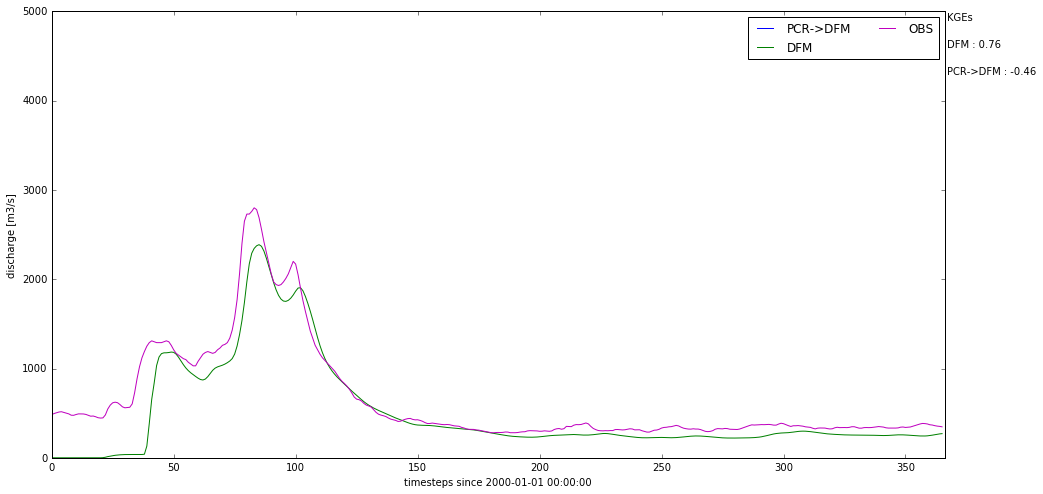

In [15]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)